## Industrial Fire Detection

Here, we will be using the dataset smoke_detection_iot.csv, downloaded from [Kaggle](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset). It was created by Stefan Blattmann in his project [Real-time Smoke Detection with AI-based Sensor Fusion](https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6#toc-model-details-9). We will be using it to explore what can be learned about the minimum information needed to determine if there is fire present. It contains over 62M rows of tested atmospheric conditions and wether or not fire was present.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

In [74]:
# Load the dataset
df = pd.read_csv('data/smoke_detection_iot.csv')
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


Feature Description

- UTC : The time when experiment was performed.
- Temperature : Temperature of Surroundings. Measured in Celsius
- Humidity : The air humidity during the experiment.
- TVOC : Total Volatile Organic Compounds. Measured in ppb (parts per billion)
- eCo2 : CO2 equivalent concentration. Measured in ppm (parts per million)
- Raw H2 : The amount of Raw Hydrogen present in the surroundings.
- Raw Ethanol : The amount of Raw Ethanol present in the surroundings.
- Pressure : Air pressure. Measured in hPa
- PM1.0 : Paticulate matter of diameter less than 1.0 micrometer .
- PM2.5 : Paticulate matter of diameter less than 2.5 micrometer.
- NC0.5 : Concentration of particulate matter of diameter less than 0.5 micrometers.
- NC1.0 : Concentration of particulate matter of diameter less than 1.0 micrometers.
- NC2.5 : Concentration of particulate matter of diameter less than 2.5 micrometers.
- CNT : Simple Count.
- Fire Alarm : (Reality) If fire was present then value is 1 else it is 0.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


All numeric, no NaNs, great.

In [76]:
df.describe()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,62630.000000,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,31314.500000,1.654792e+09,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,18079.868017,1.100025e+05,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,0.000000,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15657.250000,1.654743e+09,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,31314.500000,1.654762e+09,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,46971.750000,1.654778e+09,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,62629.000000,1.655130e+09,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


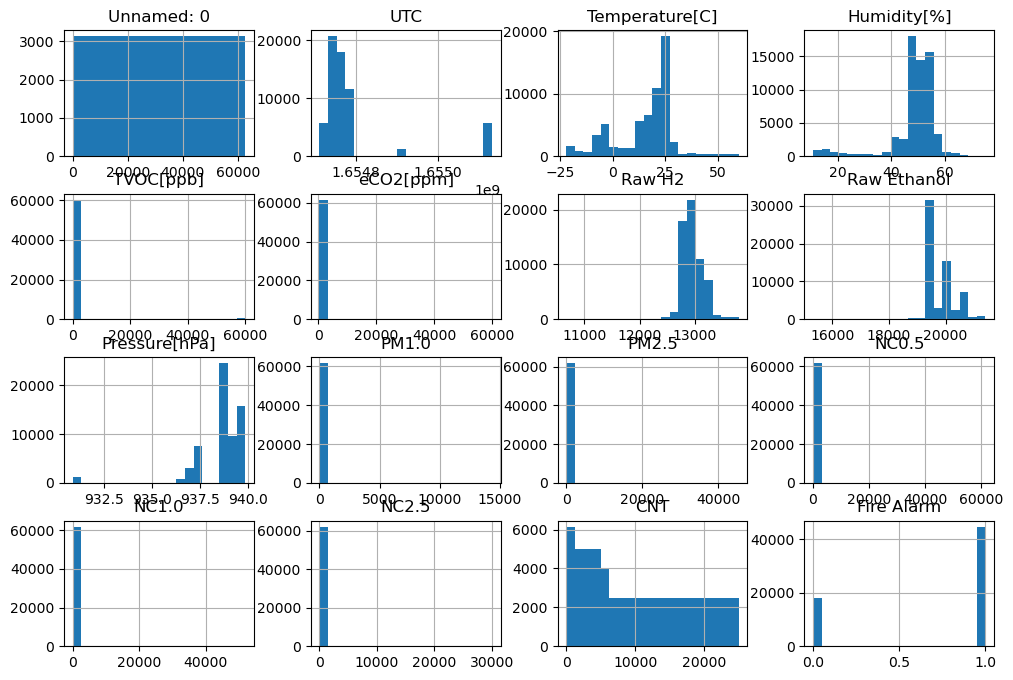

In [77]:
# Taking a look at distributions
df.hist(bins=20, figsize=(12, 8))
plt.show()

We will be modeling using atmospheric data to predict wether or not there is fire present, we will drop Unnamed, UTC, and CNT, as they have do not reflect atmospheric data.

In [78]:
# Drop unnecessary columns
df = df.drop(["Unnamed: 0", "UTC", "CNT"], axis=1)

Logically, all features will have a relationship with the target 'Fire Alarm'. Fire will affect the temperature, humidity, and pressure of the air around it. Fire will consume H2, ethanol, or VOCs. It will also create detectable VOCs in Class A fires which it will then consume. Fire will also create particulates, which is the basis of how smoke detectors work and how this dataset was created. We will create a baseline model and determine what features are most important to see what we can remove and still be reliable.

In [79]:
# Seperate independent and dependent data, then training and test sets, set random_state to 42 for repeatability
features1 = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']
target1 = 'Fire Alarm'

X1 = df[features1]
y1 = df[target1]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify=y1, test_size=0.2, random_state=42)

In [80]:
# Start with a logistic regression
# We don't have to use pipelines, but we will just because I was using them while testing different things

# Using MinMaxScaler due to a variety of distributions
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, features1)])
lr = LogisticRegression(max_iter=1000)
pipelinelr = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr)])

In [81]:
# Check accuracy, recall, and confusion matrix on test data

# Fit on train, predict on test
pipelinelr.fit(X_train1, y_train1)
y_pred1 = pipelinelr.predict(X_test1)

print(pipelinelr.score(X_test1, y_test1))
print(recall_score(y_test1, y_pred1))
print(confusion_matrix(y_test1, y_pred1))

0.8845601149608814
0.9572114847503073
[[2512 1063]
 [ 383 8568]]


We have a precision of 88.93%, meaning we have a false alarm rate of 11.07%, which is fine. However, we've missed 4.3% of actual fires. This is not acceptable. We are priotitizing recall because a false alarm is not desirable, but an unidentified fire could have dramatic consequences. We will try to improve this model by tuning hyperparameters.

In [82]:
# Setting hyperparameters and checking them via cross validation
param_grid = {'classifier__C': [ 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['lbfgs', 'liblinear', 'saga']}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipelinelr, param_grid=param_grid, cv=cv)
grid_search.fit(X_train1, y_train1)

c:\Users\Fagan\anaconda3\envs\learn-env4\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Fagan\anaconda3\envs\learn-env4\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Fagan\anaconda3\envs\learn-env4\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Fagan\anaconda3\envs\learn-env4\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Fagan\anaconda3\envs\learn-env4\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Fagan\anaconda3\envs\

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Temperature[C]',
                                                                          'Humidity[%]',
                                                                          'TVOC[ppb]',
                                                                          'eCO2[ppm]',
                                                                          'Raw '
                                                                          'H2',
                                                                          'Raw '
                                                                          'Ethanol',
                                                                          'Pressure[hPa]',
                                                                          'PM1.0',
                                                                          'PM2.5',
                                                                          'NC0.5',
                                                                          'NC1.0',
                                                                          'NC2.5'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                           10000],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['lbfgs', 'liblinear', 'saga']})

In [83]:
# Print the best hyperparameters
print(grid_search.best_params_)
print(grid_search.best_score_)

print(grid_search.score(X_test1, y_test1))

# Print the confusion matrix for the test data
y_pred1 = grid_search.predict(X_test1)
print(confusion_matrix(y_test1, y_pred1))

print(recall_score(y_test1, y_pred1))


{'classifier__C': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
0.8954773737626036
0.8937410186811432
[[2726  849]
 [ 482 8469]]
0.9461512680147469


That is worse from a false negative perspective. Let's try another model.

In [84]:
# Use a decision tree with default arguments, set random state for repeatablility

dt = DecisionTreeClassifier(random_state=42)
pipelinedt = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', dt)])
pipelinedt.fit(X_train1, y_train1)

print(pipelinedt.score(X_test1, y_test1))
y_pred1 = pipelinedt.predict(X_test1)

print(confusion_matrix(y_test1, y_pred1))

1.0
[[3575    0]
 [   0 8951]]


Great, let's make sure it is not a one off result.

In [85]:
#Checking cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipelinedt, X_train1, y_train1, cv=cv)
print(cv_scores)
print(cv_scores.mean())

[0.99950105 0.99970063 0.99980042 0.99980042 0.9997006 ]
0.999700622704297


This works, as expected. We will go beyond a decision tree to a Random Forest for robustness.

In [86]:
rfc = RandomForestClassifier(n_estimators=100)
pipelinerf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rfc)])

# Cross Validate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipelinerf, X_train1, y_train1, cv=cv)
print(cv_scores)
print(cv_scores.mean())

# Check accuracy
pipelinerf.fit(X_train1, y_train1)
print(pipelinerf.score(X_test1, y_test1))
print(confusion_matrix(y_test1, pipelinerf.predict(X_test1)))

[1.         0.99990021 0.99980042 0.99990021 0.9998004 ]
0.9998802474882588
1.0
[[3575    0]
 [   0 8951]]


In [87]:
feature_importances1 = pd.DataFrame({'Feature': features1, 'Importance': rfc.feature_importances_})

print("Feature importances for random forest model:")
print(feature_importances1)

Feature importances for random forest model:
           Feature  Importance
0   Temperature[C]    0.040681
1      Humidity[%]    0.099575
2        TVOC[ppb]    0.232311
3        eCO2[ppm]    0.016444
4           Raw H2    0.054557
5      Raw Ethanol    0.145873
6    Pressure[hPa]    0.238974
7            PM1.0    0.065009
8            PM2.5    0.027001
9            NC0.5    0.053231
10           NC1.0    0.022168
11           NC2.5    0.004176


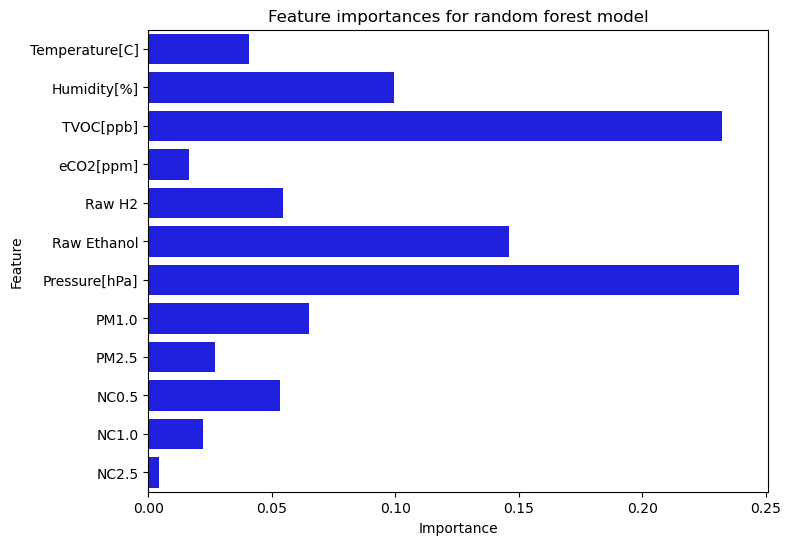

In [88]:
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances1, color="b")
plt.title("Feature importances for random forest model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

We can see that we can use smoke detectors to detect fire. Let's see if we can do it without them.

In [101]:
# No particulate information, train test split setting random state for repeatablility
features2 = ['Temperature[C]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]']
target2 = 'Fire Alarm'

X2 = df[features2]
y2 = df[target2]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, test_size=0.2, random_state=42)

In [102]:
# Instantiate a new model
preprocessor2 = ColumnTransformer(transformers=[('num', numeric_transformer, features2)])
rfc2 = RandomForestClassifier(n_estimators=100)
pipelinerf2 = Pipeline(steps=[('preprocessor', preprocessor2), ('classifier', rfc2)])

In [103]:
# Cross Validate
cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores2 = cross_val_score(pipelinerf2, X_train2, y_train2, cv=cv2)
print(cv_scores2)
print(cv_scores2.mean())

# Check accuracy, recall
pipelinerf2.fit(X_train2, y_train2)
print(pipelinerf2.score(X_test2, y_test2))
y_pred2 = pipelinerf2.predict(X_test2)
print(confusion_matrix(y_test2, y_pred2))

[0.99990021 0.99980042 0.99970063 0.99990021 0.9998004 ]
0.9998203732242132
0.9999201660546064
[[3575    0]
 [   1 8950]]


In [104]:
# Check Feature Importances
feature_importances2 = pd.DataFrame({'Feature': features2, 'Importance': rfc2.feature_importances_})

print("Feature importances for random forest model:")
print(feature_importances2)

Feature importances for random forest model:
          Feature  Importance
0  Temperature[C]    0.069436
1       TVOC[ppb]    0.252827
2       eCO2[ppm]    0.028451
3          Raw H2    0.118487
4     Raw Ethanol    0.176938
5   Pressure[hPa]    0.353861


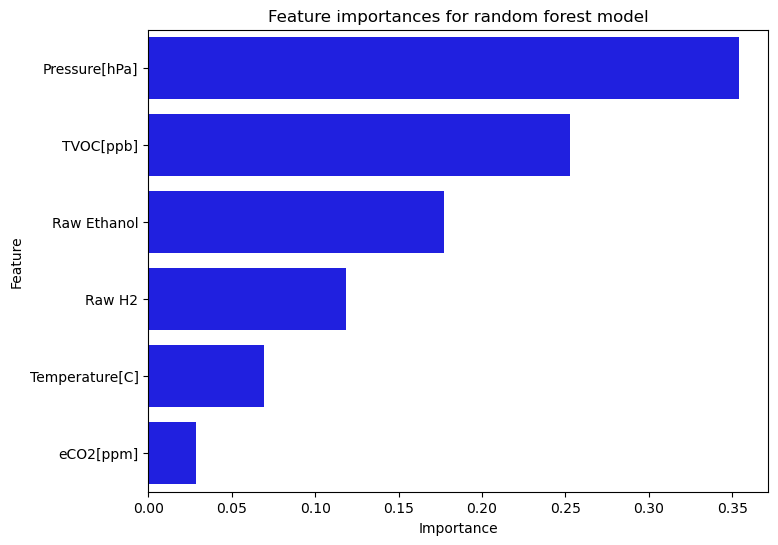

In [106]:
feature_importances_sorted2 = feature_importances2.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances_sorted2, color="b")
plt.title("Feature importances for random forest model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

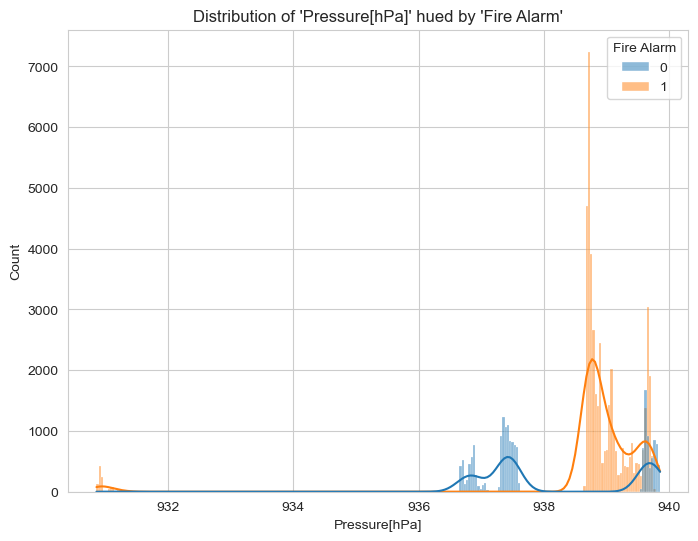

In [107]:
# Verify that they make sense
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Pressure[hPa]', hue='Fire Alarm', kde=True)
plt.title("Distribution of 'Pressure[hPa]' hued by 'Fire Alarm'")
plt.xlabel('Pressure[hPa]')
plt.ylabel('Count')
plt.show()

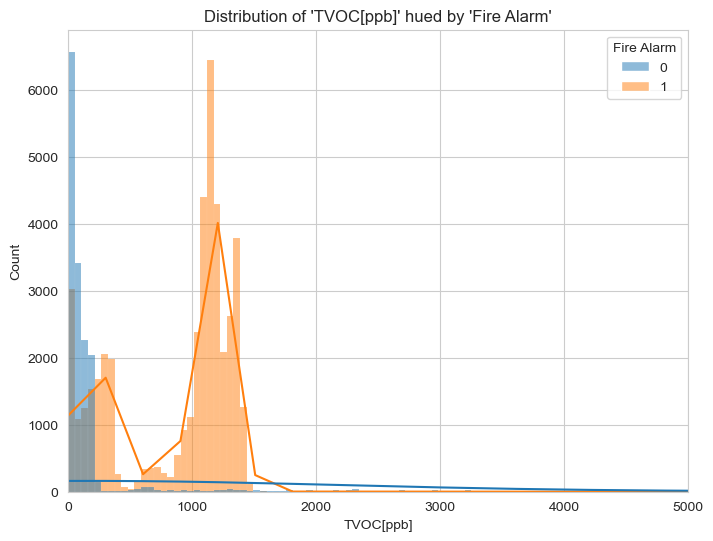

In [108]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='TVOC[ppb]', hue='Fire Alarm', kde=True)
plt.xlim(0, 5000)
plt.title("Distribution of 'TVOC[ppb]' hued by 'Fire Alarm'")
plt.xlabel('TVOC[ppb]')
plt.ylabel('Count')
plt.show()

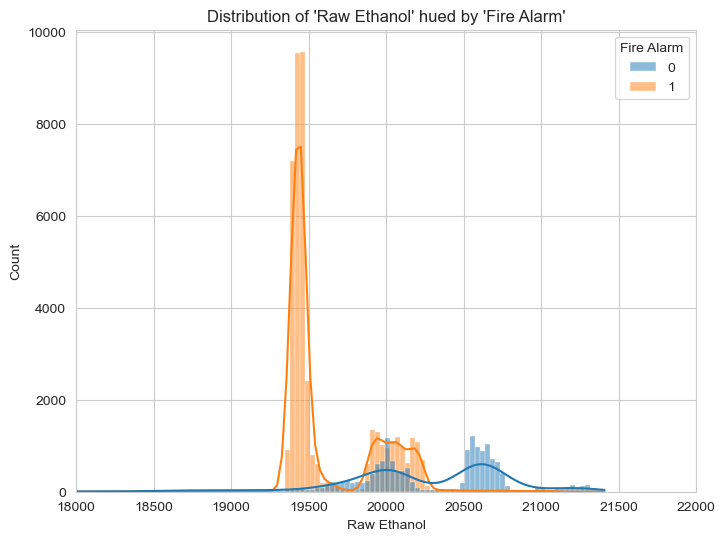

In [109]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Raw Ethanol', hue='Fire Alarm', kde=True)
plt.xlim(18000, 22000)
plt.title("Distribution of 'Raw Ethanol' hued by 'Fire Alarm'")
plt.xlabel('Raw Ethanol')
plt.ylabel('Count')
plt.show()

The most important features have clearly visible areas of fire/no fire, so our models results make sense. Let's see if we can learn more about what features combine to give us good results.

In [110]:
combinations = []
for i in range(1, len(features2) + 1):
    combinations += itertools.combinations(features2, i)

recall_scores = {}
for combo in combinations:
    X_train_combo = X_train2[list(combo)]
    X_test_combo = X_test2[list(combo)]
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_combo, y_train2)
    y_pred = rf.predict(X_test_combo)
    recall = recall_score(y_test2, y_pred)
    recall_scores[combo] = recall

ranked_combinations = sorted(recall_scores.items(), key=lambda x: x[1], reverse=True)
for i, combo in enumerate(ranked_combinations):
    print(f"Rank {i + 1}: Features: {combo[0]}, Recall score: {combo[1]}")

Rank 1: Features: ('Temperature[C]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw Ethanol'), Recall score: 1.0
Rank 2: Features: ('TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol'), Recall score: 1.0
Rank 3: Features: ('TVOC[ppb]', 'eCO2[ppm]', 'Raw Ethanol', 'Pressure[hPa]'), Recall score: 1.0
Rank 4: Features: ('TVOC[ppb]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]'), Recall score: 1.0
Rank 5: Features: ('Temperature[C]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol'), Recall score: 1.0
Rank 6: Features: ('TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]'), Recall score: 1.0
Rank 7: Features: ('Temperature[C]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]'), Recall score: 1.0
Rank 8: Features: ('TVOC[ppb]', 'Raw Ethanol', 'Pressure[hPa]'), Recall score: 0.9998882806390348
Rank 9: Features: ('Temperature[C]', 'TVOC[ppb]', 'Raw H2', 'Pressure[hPa]'), Recall score: 0.9998882806390348
Rank 10: Features: ('Temperature[C]', 'TVOC[ppb]', 'Raw Ethanol', 'Pressure[hPa

Let's try even less features.

In [111]:
# Set new features
features3 = ['TVOC[ppb]', 'Raw Ethanol', 'Pressure[hPa]']
target3 = 'Fire Alarm'

X3 = df[features3]
y3 = df[target3]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y3, test_size=0.2, random_state=42)

# New Model
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(X_train3, y_train3)
y_pred3 = rf3.predict(X_test3)

print("Confusion matrix for the random forest model:")
print(confusion_matrix(y_test3, y_pred3))

Confusion matrix for the random forest model:
[[3572    3]
 [   1 8950]]


In [112]:
# Check feature importances
feature_importances3 = pd.DataFrame({'Feature': features3, 'Importance': rf3.feature_importances_})

print("Feature importances for random forest model:")
print(feature_importances3)

Feature importances for random forest model:
         Feature  Importance
0      TVOC[ppb]    0.326626
1    Raw Ethanol    0.352540
2  Pressure[hPa]    0.320834


Fuel source has become more important than pressure.

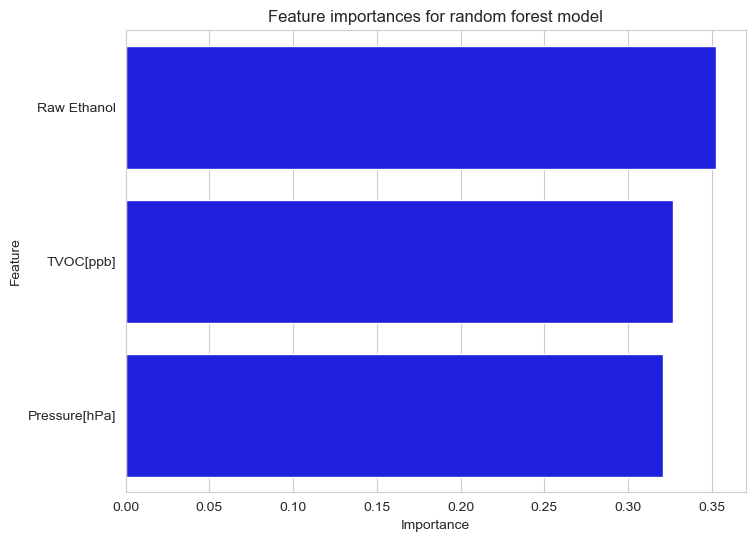

In [113]:
feature_importances_sorted3 = feature_importances3.sort_values('Importance', ascending=False)


plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances_sorted3, color="b")
plt.title("Feature importances for random forest model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Running every combination has given us valuable insight into the minimum viable instrumentation to detect fire.